In [3]:
import sys
sys.path.append("../..")
import torch
from pathlib import Path
import scipy
import numpy as np
from lru.architectures import DLRU, DLRUConfig
from lru.reduction import lru_reduction_pipeline
import matplotlib.pyplot as plt
import torchid.metrics  # pip install pytorch-ident
import copy

In [4]:
# Load data
data_folder = ("F16GVT_Files", "BenchmarkData")

# file_name = "F16Data_SineSw_Level5.mat"
#
# file_name = "F16Data_FullMSine_Level7.mat"
# file_name = "F16Data_FullMSine_Level5.mat"
# file_name = "F16Data_FullMSine_Level4_Validation.mat"
file_name = "F16Data_FullMSine_Level6_Validation.mat"
# file_name = "F16Data_SineSw_Level6_Validation.mat"
file_path = Path(*data_folder) / file_name
data = scipy.io.loadmat(file_path)

In [5]:
#run = "ckpt_large_reg_hankel"
#run = "ckpt_large_reg_hankel_cc"
run = "ckpt_large_reg_modal"  # lasso on eigs abs val
#run = "ckpt_large_no_reg"
# run = "ckpt_large_no_reg_last"
# run = "ckpt_small_no_reg"
# run = "ckpt_small_reg"

In [6]:
modes = 20 # modes to be kept
#reduction_method = "modal_singular_perturbation" # modal | balanced_truncation | balanced_truncation_cc
#reduction_method = "balanced_singular_perturbation"
reduction_method = "modal_singular_perturbation"
#reduction_method = "balanced_truncation"

In [7]:
ckpt = torch.load(Path("ckpt")/ f"{run}.pt", map_location="cpu")
cfg = ckpt["cfg"]
scaler_u = ckpt["scaler_u"]
scaler_y = ckpt["scaler_y"]

/Users/marco.forgione/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
u_test = data["Force"].T  # Or force
y_test = data["Acceleration"].T

In [9]:
# Load model
config = DLRUConfig(
    d_model=cfg.d_model, d_state=cfg.d_state, n_layers=cfg.n_layers, ff=cfg.ff
)
model = DLRU(1, 3, config)
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

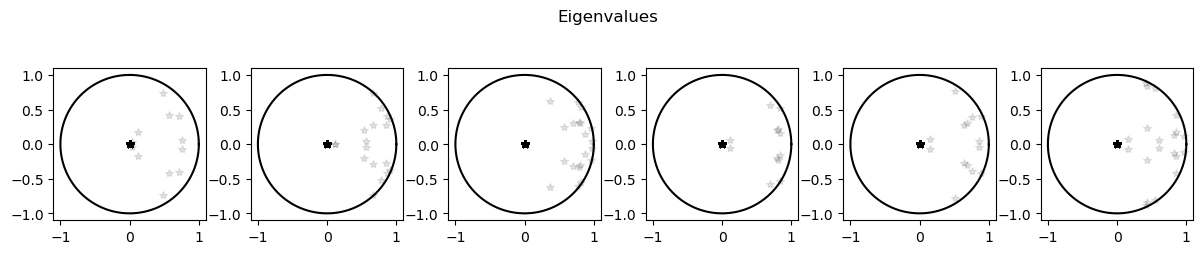

In [10]:
fig, ax = plt.subplots(1, config.n_layers, figsize=(2 * config.n_layers, 2.5))
t = np.linspace(0, 2 * np.pi, 1000)
plt.suptitle("Eigenvalues")
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    lambdas, *_ = layer.lru.ss_params()
    lambdas = lambdas.detach()
    ax[idx].plot(np.cos(t), np.sin(t), "-k")
    ax[idx].plot(lambdas.real, lambdas.imag, "k*", alpha=0.1)  # lambdas.real
    ax[idx].plot(lambdas.real, -lambdas.imag, "k*", alpha=0.1)  # lambdas.real
    ax[idx].set_box_aspect(1)
plt.tight_layout()

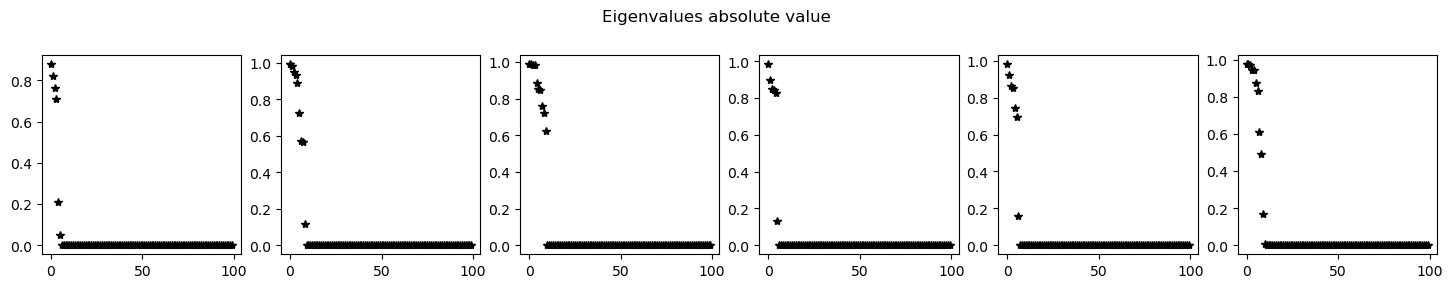

In [11]:
fig, ax = plt.subplots(1, config.n_layers, figsize=(3 * config.n_layers, 3.0))
plt.suptitle("Eigenvalues absolute value")
t = np.linspace(0, 2 * np.pi, 1000)
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    lambdas, *_ = layer.lru.ss_params()
    lambdas = lambdas.detach().numpy()
    ax[idx].plot(np.sort(np.abs(lambdas))[::-1], "k*")  # lambdas.real
    ax[idx].set_box_aspect(1)

(0.0, 20.0)

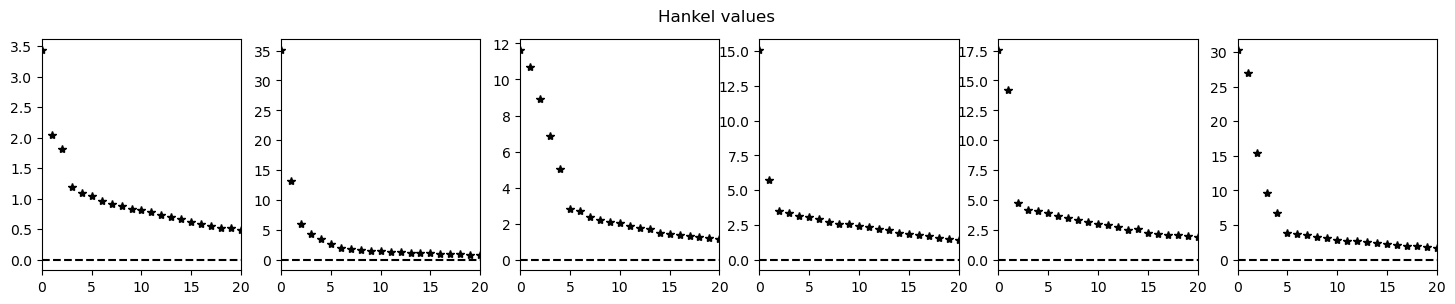

In [12]:
#model = model.double()
fig, ax = plt.subplots(1, config.n_layers, figsize=(3 * config.n_layers, 3.0), sharex=True)#, sharey=True)
plt.suptitle("Hankel values")
t = np.linspace(0, 2 * np.pi, 1000)
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    #hankel = layer.lru.hankel_singular_values_double(cc=cc_reduction)
    hankel = layer.lru.hankel_singular_values(cc=True if reduction_method=="balanced_truncation_cc" else False)
    hankel = hankel.detach().numpy()
    ax[idx].plot(hankel, "k*", alpha=0.99)
    ax[idx].plot(np.zeros(hankel.shape), "k--"), 
#ax[0].set_ylim([0, 0.1])
ax[0].set_xlim([0, 20])
#plt.tight_layout()

In [13]:
model_reduced = copy.deepcopy(model)

for block in model_reduced.blocks:

    # reduction pipeline
    ss_params = block.lru.ss_params()
    ss_params = [param.detach().numpy() for param in ss_params]
    lambdas, B, C, D = ss_params
    lambdas_red, B_red, C_red, D_red = lru_reduction_pipeline(lambdas, B, C, D,  modes=modes, method=reduction_method)


    params_red = [lambdas_red.astype(np.complex64), B_red.astype(np.complex64), C_red.astype(np.complex64), D_red.astype(np.float32)]
    params_red = [torch.tensor(param_red) for param_red in params_red]
    block.lru.replace_ss_params(*params_red)

In [14]:
model_reduced.blocks[5].lru.nu_log.shape, model.blocks[0].lru.nu_log.shape

(torch.Size([20]), torch.Size([100]))

In [15]:
params = sum(map(torch.numel, model.parameters()))
params_red = sum(map(torch.numel, model_reduced.parameters()))
reduction = 100 * (1 - params_red / params)
print(f"{params} original paramers...\n{params_red} original paramers\n{reduction}% parameter reduction")

199153 original paramers...
149713 original paramers
24.825134444371912% parameter reduction


In [16]:
ut = torch.tensor(scaler_u.transform(u_test)).unsqueeze(0).float()
with torch.no_grad():
    #    y_test_hat = model(ut, mode="scan").squeeze(0).to("cpu").numpy()
    y_test_hat = model_reduced(ut, mode="scan").squeeze(0).to("cpu").numpy()

y_test_hat = scaler_y.inverse_transform(y_test_hat)

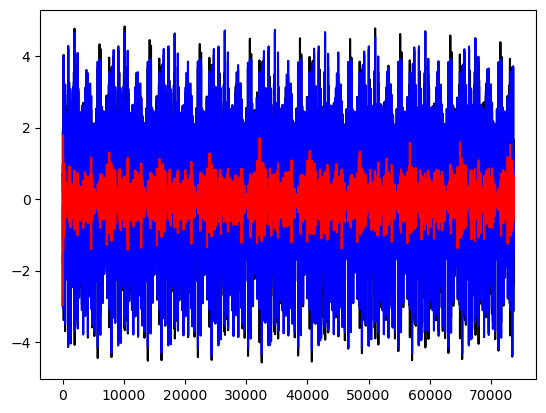

In [17]:
plt.figure()
plt.plot(y_test[:, 0], "k")
plt.plot(y_test_hat[:, 0], "b")
plt.plot(y_test_hat[:, 0] - y_test[:, 0], "r")

In [18]:
fit = torchid.metrics.fit_index(y_test, y_test_hat)
rmse = torchid.metrics.rmse(y_test, y_test_hat) * 100
nrmse = torchid.metrics.nrmse(y_test, y_test_hat)


print(f"{fit=} \n{rmse=} \n{nrmse=}")

fit=array([85.4706836 , 89.83750032, 74.46776794]) 
rmse=array([19.46179766, 17.14867832, 39.54865877]) 
nrmse=array([0.14529316, 0.101625  , 0.25532232])


Results on "F16Data_FullMSine_Level6_Validation.mat", hankel-regularized model:

fit=array([85.25872139, 89.24442771, 75.84110443]) 

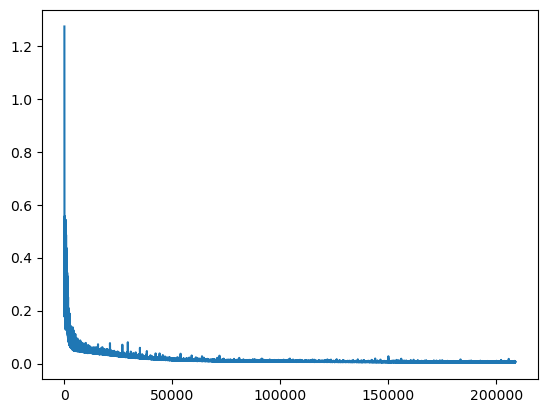

In [19]:
plt.figure()
plt.plot(ckpt["LOSS"])
#plt.ylim([0.0, 0.2])